In [1]:
import pickle
import datetime

import numpy as np

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.0+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [5]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=2, F1=3 / 2, F=1
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=2, F1=3 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=2, F1=5 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=2, F1=5 / 2, F=3
    ),
]

polarizations = [
    [couplings.polarization_σm, couplings.polarization_σp],
    [couplings.polarization_σm, couplings.polarization_σp],
    [couplings.polarization_σm, couplings.polarization_σp],
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [6]:
# ignore small decay to J=4
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=4,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [7]:
odepars = lindblad_julia.odeParameters(
    Ω0="ΩQ0*variable_on_off(t, ton0, toff0, phase0)",
    ΩQ0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    P0="sin(ω0*t + φ0)",
    Pσm0="P0>0",
    Pσp0="P0<=0",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    Ω1="ΩQ1*variable_on_off(t, ton1, toff1, phase1)",
    ΩQ1=1 * hamiltonian.Γ,
    δ1=0.0,
    P1="sin(ω1*t + φ1)",
    Pσm1="P1>0",
    Pσp1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    Ω2="ΩQ2*variable_on_off(t, ton2, toff2, phase2)",
    ΩQ2=1 * hamiltonian.Γ,
    δ2=0.0,
    P2="sin(ω2*t + φ2)",
    Pσm2="P2>0",
    Pσp2="P2<=0",
    ω2=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ2=0.0,  # polarization switching phase [rad]
    Ω3="ΩQ3*variable_on_off(t, ton3, toff3, phase3)",
    ΩQ3=1 * hamiltonian.Γ,
    δ3=0.0,
    P3="sin(ω3*t + φ3)",
    Pσm3="P3>0",
    Pσp3="P3<=0",
    ω3=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ3=0.0,  # polarization switching phase [rad]
    # on/off parameters
    ton0=1e-6,
    toff0=3e-6,
    ton1=1e-6,
    toff1=3e-6,
    ton2=1e-4,
    toff2=3e-6,
    ton3=1e-6,
    toff3=3e-6,
    phase0=0.0,
    phase1=np.pi / 2,
    phase2=np.pi,
    phase3=3 * np.pi / 2,
)

In [8]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    
ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 2, F₁ = 3/2, F = 1>","|B, J = 2, F₁ = 3/2, F = 2>","|B, J = 2, F₁ = 5/2, F = 2>","|B, J = 2, F₁ = 5/2, F = 3>"
states,,,,
"|X, J = 0>",0.182748,0.186918,0.000068,0.000000
"|X, J = 2>",0.817252,0.813037,0.946544,0.945582
"|X, J = 4>",0.000000,0.000045,0.053388,0.054418


In [10]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 2, F₁ = 3/2, F = 1>","|B, J = 2, F₁ = 3/2, F = 2>","|B, J = 2, F₁ = 5/2, F = 2>","|B, J = 2, F₁ = 5/2, F = 3>"
states,,,,
"|X, J = 0, F₁ = 1/2, F = 0>",0.120282,0.000000,0.000000,0.000000e+00
"|X, J = 0, F₁ = 1/2, F = 1>",0.062466,0.186918,0.000068,0.000000e+00
"|X, J = 2, F₁ = 3/2, F = 1>",0.682614,0.077236,0.000339,0.000000e+00
"|X, J = 2, F₁ = 3/2, F = 2>",0.133151,0.733602,0.002568,4.825780e-05
"|X, J = 2, F₁ = 5/2, F = 2>",0.001487,0.001778,0.885019,4.228653e-02
"|X, J = 2, F₁ = 5/2, F = 3>",0.000000,0.000421,0.058619,9.032470e-01
"|X, J = 4, F₁ = 7/2, F = 3>",0.000000,0.000045,0.053388,1.770165e-03
"|X, J = 4, F₁ = 7/2, F = 4>",0.000000,0.000000,0.000000,5.264747e-02
"|X, J = 4, F₁ = 9/2, F = 4>",0.000000,0.000000,0.000000,5.939334e-07


In [11]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J4 = states.QuantumSelector(
    J=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)


In [12]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=2, electronic=states.ElectronicState.X),
    obe_system.QN,
)

In [13]:
odepars.ton0 = 1e-6
odepars.ton1 = 1e-6
odepars.ton2 = 1e-6
odepars.ton3 = 1e-6
odepars.toff0 = 3e-6
odepars.toff1 = 3e-6
odepars.toff2 = 3e-6
odepars.toff2 = 3e-6
odepars.phase0 = 0.0
odepars.phase1 = np.pi / 2
odepars.phase2 = np.pi
odepars.phase2 = 3 * np.pi / 2

In [14]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)

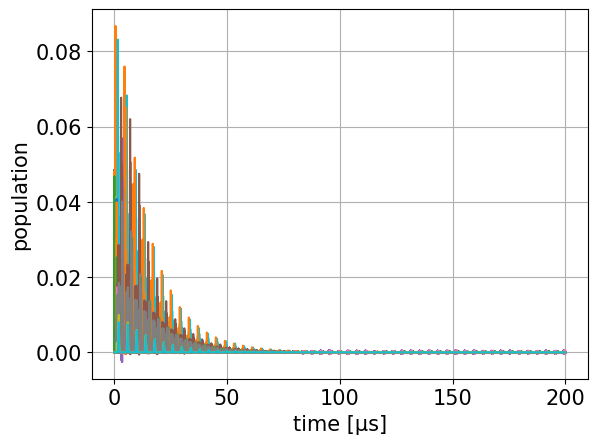

In [16]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

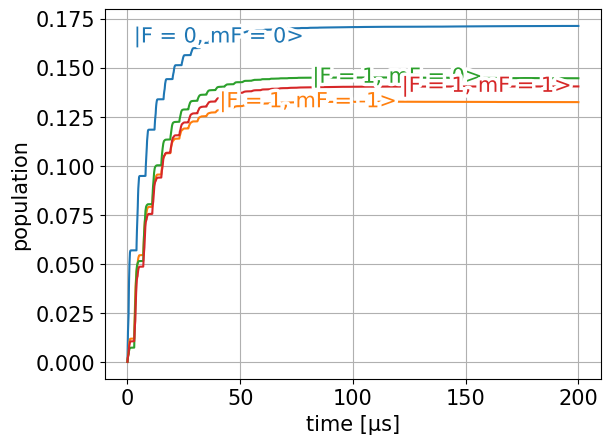

In [18]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J0
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J0].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

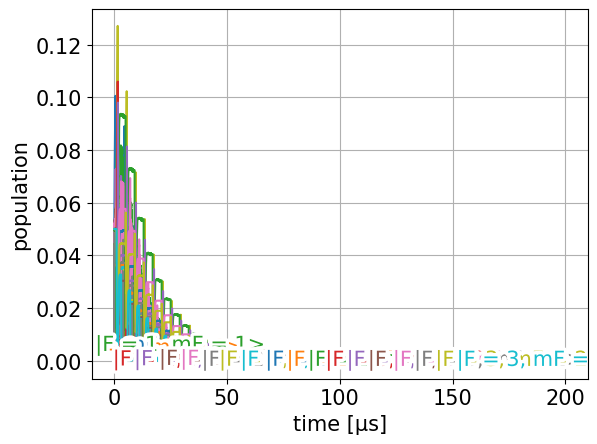

In [19]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J2
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J2].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

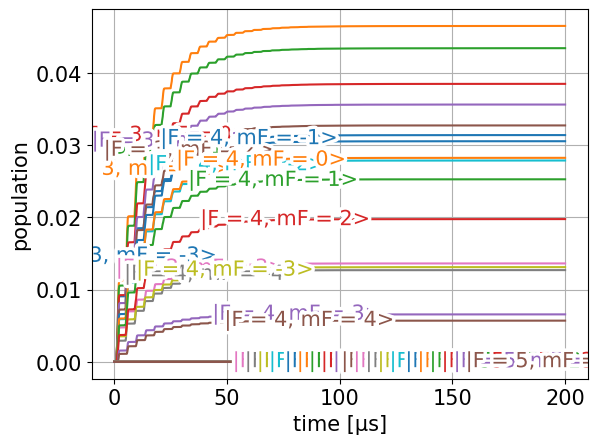

In [21]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J4
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J4].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


In [22]:
from scipy.integrate import trapezoid

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")

# photons = 10.8


# Turn off the two Q transitions that have branching to J=0

In [23]:
odepars.ton0 = 0e-6
odepars.ton1 = 0e-6
odepars.ton2 = 1e-6
odepars.ton3 = 1e-6
odepars.toff0 = 1e-3
odepars.toff1 = 1e-3
odepars.toff2 = 1e-6
odepars.toff2 = 1e-6
odepars.phase0 = 3.2
odepars.phase1 = 3.2
odepars.phase2 = 0.0
odepars.phase2 = np.pi
odepars.ΩQ2 = 0.4 * hamiltonian.Γ
odepars.ΩQ3 = 0.4 * hamiltonian.Γ

In [24]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [27]:
results = lindblad_julia.do_simulation_single(problem, config=config)

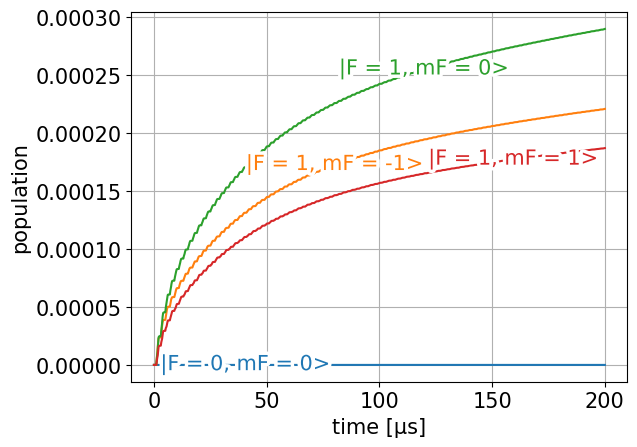

In [28]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J0
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J0].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


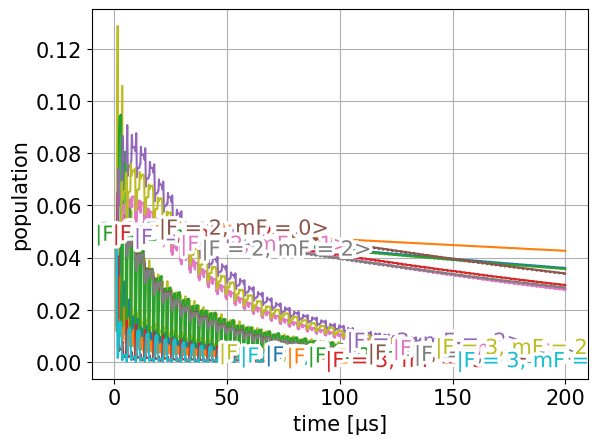

In [29]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J2
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J2].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


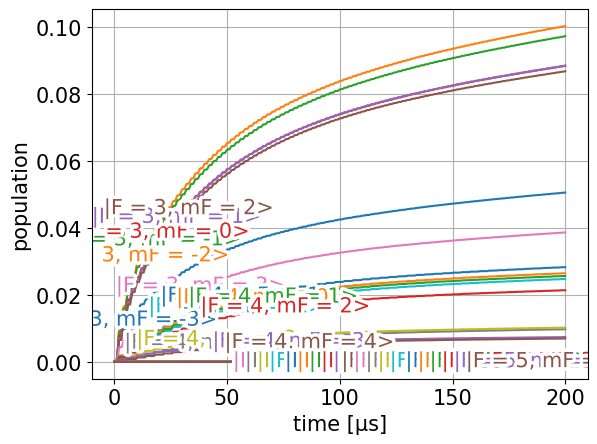

In [30]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J4
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J4].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


In [31]:
from scipy.integrate import trapezoid

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")


# photons = 13.3
